In [2]:
# Preamble  here, add paths and import relevant modules
import os
import sys
sys.path.append('/'.join(os.getcwd().split('/')[:-1]))
import util
reload(util)
import numpy as np 
import sklearn
from sklearn import datasets
from scipy.sparse.linalg import eigsh
from numpy.random import permutation
% matplotlib inline
import matplotlib.pyplot as plt

# Tutorial 1 --- Intro to Graph Laplacian Algorithms

Graphs Laplacians have been widely used in both clustering and image processing. In clustering, the most popular algorithm used is `spectral clustering`, which first does a spectral embedding of the original data, and then applies `k-means` to the transform domain. In image processing, the Graph Laplacian is mainly used as a non-local smoothing term $X^TLX$ to boost the performance in images with lots of self-similarities(e.g., texture rich images). 

Recently, several new algorithms using the graph Laplacian has been proposed by Prof. Andrea Bertozzi and her collaborators. Unlike methods before, these algorithms aims to approximately minimize the full Graph-Cut energy, and have showned to outperform the standard algorithms mentioned above. These methods also have their origins in the area of PDE's and material science, and can be seen as an elegant connection between the world of machine learning and differential equation. 

I have recently implemented these algorithms into a python package. These tutorials aim to introduce the algorithms as well as the usage of the code.

## 1.1 Two Moons Toy Dataset

In this tutorial, we will use a toy dataset called `Two Moons` for demonstration purpose. Other datas will be explored in future tutorials. The code below generates the Two Moons dataset with 500 sample points having different variances.

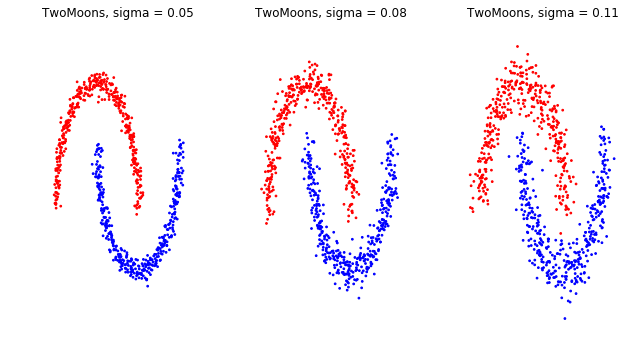

In [4]:
# Two Moons dataset with different noise levels
n_samples = 800
x = np.zeros([n_samples,2,3])
y = np.zeros([n_samples,3])
plt.figure(1)
for i in range(3):
    x[:,:,i],y[:,i] = sklearn.datasets.make_moons(n_samples=n_samples, noise=0.02+.03*(i+1),shuffle = False)
    n_mid = int(n_samples/2)
    color = 'r'*n_mid + 'b'*n_mid
    plt.subplot(1,3,i+1)
    plt.scatter(x[:,0,i],x[:,1,i],s = 3, color = color)
    plt.axis('off')
    plt.title('TwoMoons, sigma = {sig}'.format(sig = 0.02+.03*(i+1)))
plt.tight_layout()   
plt.rcParams['figure.figsize'] = (9, 5)
plt.show()

## 1.2 Comparison of Different Affinity Matrix

The affinity matrix are vital to the success of a graph-cut algorithm. Some commonly used affinity rules are: `0-1 nearest neighbors` , `rbf`, `cosine`. Given an affinity matrix $W$, we can build a symmetric graph Laplacian $L_s = I- D^{1/2}WD^{1/2}$ and compute its smallest eigenvectors $V$. 

A spectral embedding is the projection of $x$ onto $\mathbb{R}^k$ using the eigenvectors of the graph Laplacian $V$. This embedding can often transform non-linear, non-convex clusters into convex and linearly separable clusters. The spectral clustering algorithm simply applies `K-means` to the transformed domain

We will plot the spectral embedding of the three "twomoons" dataset using different graph kernels. Below is a plot for nearest neighbors

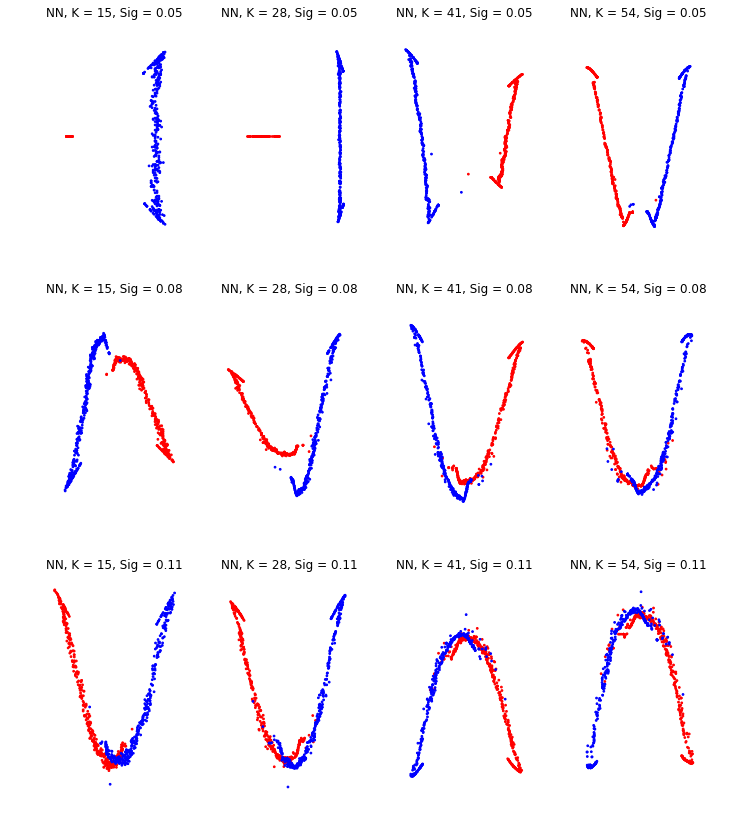

In [8]:
# rbf nearest neighbor graph
plt.figure(2)
plt.rcParams['figure.figsize'] = (12, 14)
for i in range(3):
    for j in range(4):
        raw_data = x[:,:,i]
        graph = util.BuildGraph(Eig_solver = 'arpack', affinity = 'rbf', neighbor_type = 'knearest', 
                                n_neighbors = 15+13*(j), Neig = 4,gamma =0.02+.03*(i+1) )
        graph.build_Laplacian(raw_data)
        V = graph.laplacian_matrix_['V']
        x_t = V[:,1]
        y_t = V[:,2]
        color = 'r'*n_mid + 'b'*n_mid
        plt.subplot(3,4,i*4+j+1)
        plt.scatter(x_t,y_t,s = 3, color = color)
        plt.axis('off')
        plt.title('NN, K = {K}, Sig = {sigma}'.format(K = 15+13*(j), sigma = 0.02+.03*(i+1)))
plt.show()

We can see from the embeddings that spectral clustering will work well with the nearest neighbor graphs. We will try out the  `rbf` kernel next which is also frequently used. 

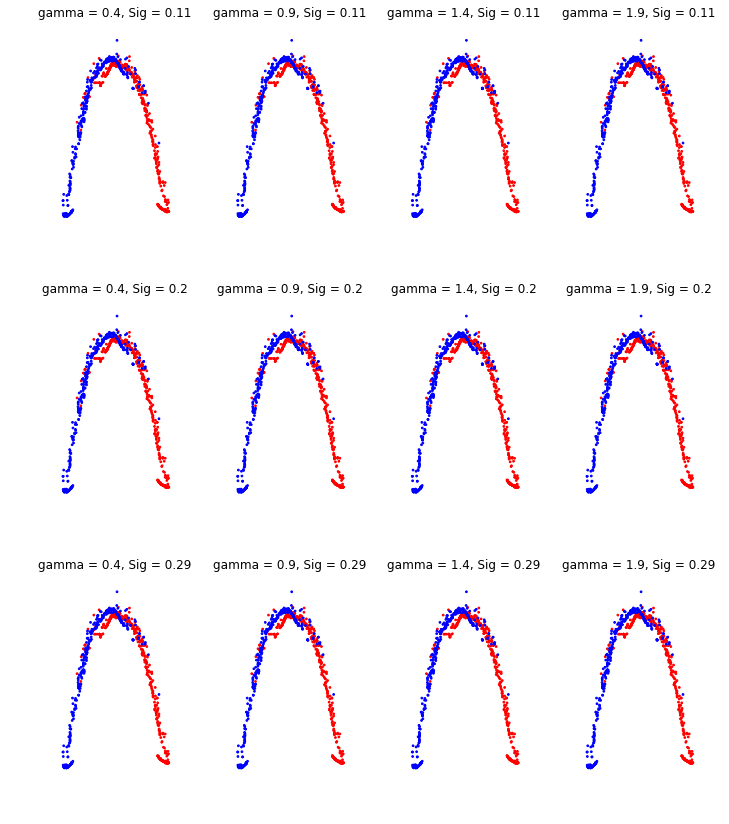

In [11]:
# rbf full graph
plt.figure(3)
plt.rcParams['figure.figsize'] = (12, 14)
for i in range(3):
    for j in range(4):
        raw_data = x[:,:,i],
        graph = util.BuildGraph(Eig_solver = 'arpack', affinity = 'rbf', neighbor_type = 'full',
                                Neig = 5,gamma = .4+.8*j)
        x_t = V[:,1]
        y_t = V[:,2]
        color = 'r'*n_mid + 'b'*n_mid
        plt.subplot(3,4,i*4+j+1)
        plt.scatter(x_t,y_t,s = 3, color = color)
        plt.axis('off')
        plt.title('gamma = {g}, Sig = {sigma}'.format(g = .4+.5*j, sigma = 0.02+.09*(i+1)))
plt.show()

We see that the non-linearities are not at all resolved for $\gamma = .4$, and significant overlap exists for larger $\gamma$s. It's fair to conclude that the `rbf` kernel is not suited for segmenting this problem

## 1.3 Demo of Semi-Supervised Graph Cut

We will demonstrate how to use the graph clustering package and show some results

First off, we will import the module and build the classifier. Here, we will specify the type of algorithm we use(in this case, `GL_fidelity`, and relevant parameters such as `eps`, `eta` and `dt`. Detailed documentations for parameters could be found in the code for LaplacianClustering class(graph_cluster folder).  You can always reset the parameters by calling `set_params()`

In [44]:
#initialization
import graph_cluster as gc
clf = gc.LaplacianClustering(scheme_type = 'GL_fidelity', eps = 1, eta = 2)

Next, we load the data into the classifier via `load_data` function. Ground truth is optional, but can be used to calculate miss-classification and also generate random fidelity. 

In [45]:
# load raw_data, ground_truth
x,y = sklearn.datasets.make_moons(n_samples=800, noise=0.02+.03*(2),shuffle = False)
clf.load_data(raw_data = x, ground_truth = y)
# generate 10% fidelity
clf.generate_random_fidelity(percent = .1)

We then build the graph via `build_graph()` function. The arguments are the parameters for constructing the graph Laplacian.

In [46]:
clf.build_graph(Eig_solver = 'arpack', affinity = 'rbf', neighbor_type = 'knearest', 
                                n_neighbors = 20, Neig = 4,gamma =0.02+.03*2 )

Finally, we simply fit the data using `fit_predict()`. The prediction results are stored in `clf.labels_`. 

u_init not provided. Generating random initial condition.
Warning, stepsize dt not supplied. Using default value .1


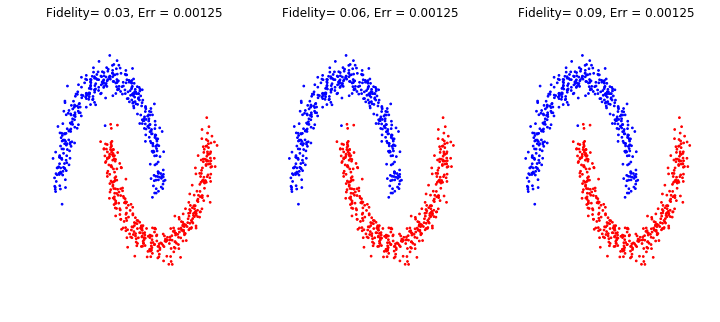

In [47]:
# Testing supervised learning
plt.figure(4)
plt.rcParams['figure.figsize'] = (12, 5)
def gen_colors(u):
    color = ""
    for l in u:
        if l>0:
            color += 'r'
        else:
            color += 'b'
    return color
#classification results
for i in range(3):
    clf.generate_random_fidelity(percent = (i+1)*.03)
    clf.fit_predict()
    plt.subplot(1,3,i+1)
    plt.scatter(x[:,0],x[:,1],s = 3, color = gen_colors(clf.labels_))
    plt.title('Fidelity= {perc}, Err = {r}'.format(perc = (i+1)*.03, r = clf.compute_error_rate()))    
    plt.axis('off')
plt.show()

Surprisingy, the number of eigenvectors is not monotone with the classification quality. It seems to decrease first and then increase as Neig gets larger. The user is welcome to try experimenting with different values of Neig. 

We will test the scheme `MBO fidelity` on the same problem. We use `set_parameters` to change the scheme type to 'MBO_fidelity'. 

In [48]:
clf.set_parameters(scheme_type='MBO_fidelity')

Note that to do a slightly different experiment, we only modify what's necessary(in this case, only the `scheme_type` is changed, nothing else) and keep the remaining parameters the same. This allows for fast experimentation. 

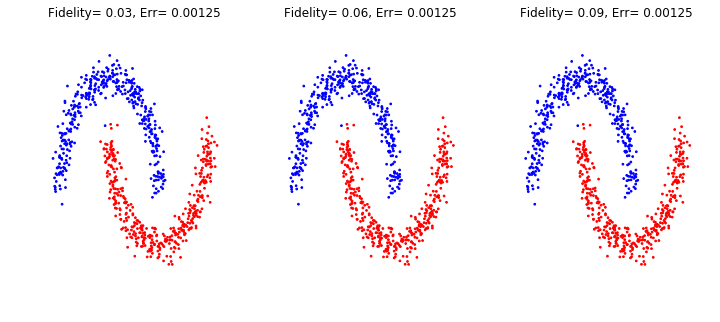

In [49]:
# Testing supervised learning
reload(gc)
plt.figure(5)
plt.rcParams['figure.figsize'] = (12, 5)
def gen_colors(u):
    color = ""
    for l in u:
        if l>0:
            color += 'r'
        else:
            color += 'b'
    return color
#classification results
for i in range(3):
    clf.generate_random_fidelity(percent = (i+1)*.03)
    clf.fit_predict()
    plt.subplot(1,3,i+1)
    plt.scatter(x[:,0],x[:,1],s = 3, color = gen_colors(clf.labels_))
    plt.title('Fidelity= {perc}, Err= {err}'.format(perc = (i+1)*.03, err = clf.compute_error_rate()))    
    plt.axis('off')
plt.show()

Seems to do a lot better. One remark is that the supervised `MBO` has an `inner loop count` constant that needs to be tuned. Too low of a loop count does degrade the prediction error. 

## 1.4 Multiclass Classification

Our classifiers can handle multi-class as well as binary class. For this demo, we use the `three_moons` dataset, which is a toy data similiar to the two moons example. 

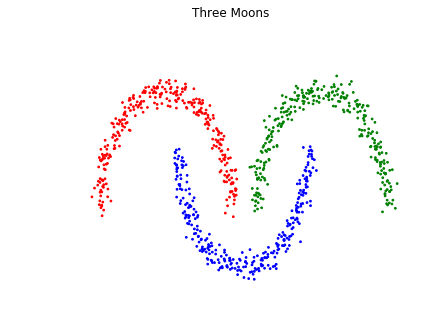

In [52]:
import data
reload(data)
plt.figure(6)
plt.rcParams['figure.figsize'] = (7, 5)
X,Y = data.three_moons(n_samples = 900, noise = .03)
palet = 'rbg'
color = [palet[c] for c in Y.astype(int)]
plt.scatter(X[:,0],X[:,1],s = 3, color = color)
plt.title('Three Moons')
plt.axis('off')
plt.rcParams['figure.figsize'] = (7, 5)
plt.show()

For a semi-supervised multiclass segmentation, simply set the numer of classes `n_class = 3`. Again, we set the classifier. 

In [58]:
#initialization
import graph_cluster as gc
clf.set_parameters(scheme_type = 'MBO_fidelity', eps = 1, eta = 2, n_class = 3)
clf.generate_initial_value()
# load raw_data
clf.load_data(raw_data = X, ground_truth = Y)
# set graph parameters
clf.build_graph(Eig_solver = 'arpack',affinity = 'rbf',
                neighbor_type = 'knearest' ,n_neighbors = 20, gamma = 1, Neig = 20)

Same as before, we simply generate some fidelity and apply `fit_predict`. The graph is a nearest neighbor graph with $30$ neighbors

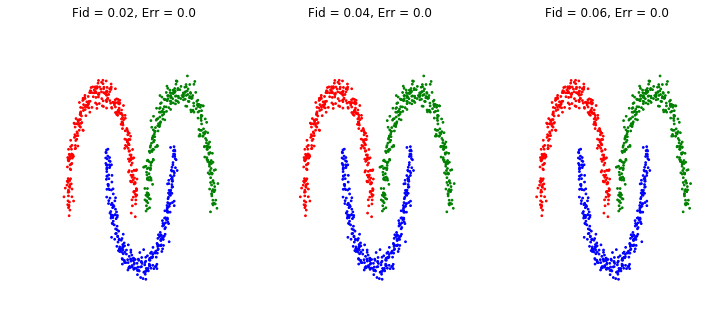

In [62]:
# Testing supervised learning
reload(gc)
plt.figure(7)
palet = 'rbg'
#classification results
for i in range(3):
    clf.generate_random_fidelity(percent = (i+1)*.02)
    clf.fit_predict()  
    plt.subplot(1,3,i+1)
    color = [palet[c] for c in clf.labels_]
    plt.scatter(X[:,0],X[:,1],s = 3, color = color)
    plt.title('Fid = {perc}, Err = {err}'.format(perc = (i+1)*.02, err = clf.compute_error_rate()))    
    plt.axis('off')   
plt.rcParams.update({'figure.figsize':(12, 5)})  
plt.show()

In both cases, it seems that the error rate is **Not** monotonic with respect to the number of eigenvectors used.(e.g., try 100 eigenvectors in this example) This shows that throwing away eigenvectors is not just a computational convenience, but may actually inprove performance! 